In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov 10 14:30:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
from torch.utils.data import TensorDataset

In [ ]:
def clean_text(text):
    if isinstance(text, (str, np.ndarray)): 
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        elif isinstance(text, np.ndarray):
            return np.array([clean_text(t) for t in text])
    elif pd.isnull(text): 
        return ""
    else:
        try:
            text = str(text)
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        except Exception as e:
            print(f"Error cleaning text: {e}, Text Type: {type(text)}, Text Value: {text}")
            return "" 

In [ ]:
labeled_data = pd.read_csv("/content/drive/MyDrive/WoS/data/WoSDataset_53949.csv")

for col in ['Keywords', 'Abstract']:
    labeled_data[col] = labeled_data[col].apply(clean_text)

labeled_data['combined_text'] = labeled_data['Keywords'] + " [SEP] " + labeled_data['Abstract']

In [ ]:
abstractslbl = labeled_data['Abstract']
keywordsslbl = labeled_data['Keywords']
domainlbl = labeled_data['Domain']
lbls = labeled_data['Label']

In [ ]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(53949, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [ ]:
labels = np.unique(domainlbl, return_counts=True)[0]
labelCounts=  np.unique(domainlbl, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 7773  5000  6303  4472 15641  8089  6671]


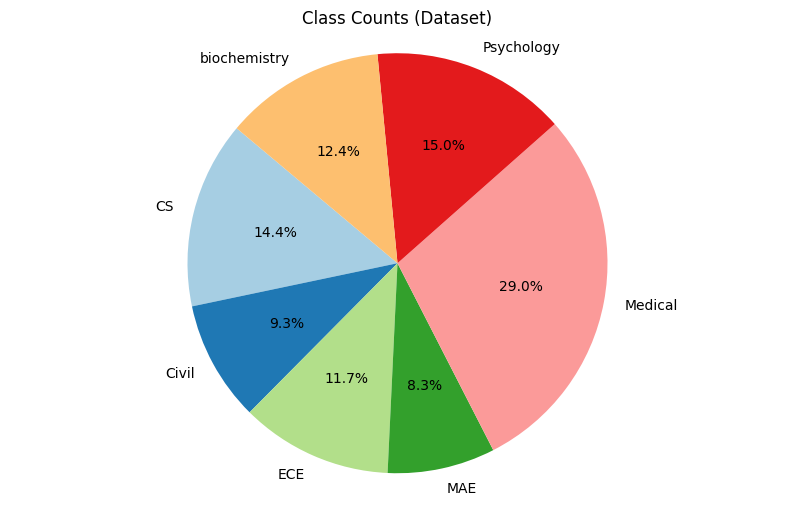

The label CS has 7773 records in the dataset.
The label Civil has 5000 records in the dataset.
The label ECE has 6303 records in the dataset.
The label MAE has 4472 records in the dataset.
The label Medical has 15641 records in the dataset.
The label Psychology has 8089 records in the dataset.
The label biochemistry has 6671 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
labeled_data_shuffled = sklearn.utils.shuffle(labeled_data)
abstracts_shuffled = labeled_data_shuffled['Abstract'].values
keywords_shuffled = labeled_data_shuffled['Keywords'].values
domains_shuffled = labeled_data_shuffled['Domain'].values
allLabels_shuffled = labeled_data_shuffled['Label'].values
allLabels_digit_shuffled = allLabels_shuffled.astype(int)

In [ ]:
print(np.shape(labeled_data_shuffled))
print(np.shape(abstracts_shuffled))
print(np.shape(keywords_shuffled))
print(np.shape(domains_shuffled))

print(labeled_data_shuffled['combined_text'][0])

(53949, 5)
(53949,)
(53949,)
(53949,)
 21dimensional nonlinear optical waves erbiumdoped optical fibre symbolic computation soliton solution soliton interaction         [SEP] 2  1dimensional nonlinear optical waves through the coherently excited resonant medium doped with the erbium atoms can be described by a 2  1dimensional nonlinear schrodinger equation coupled with the selfinduced transparency equations for such a system via the hirota method and symbolic computation linear forms one twoand nsoliton solutions are obtained asymptotic analysis is conducted and suggests that the interaction between the two solitons is elastic bright solitons are obtained for the fields e and p while the dark ones for the field n with e as the electric field p as the polarization in the resonant medium induced by the electric field and n as the population inversion profile of the dopant atoms headon interaction between the bidirectional two solitons and overtaking interaction between the unidirectional

In [ ]:
train_data, test_data = train_test_split(labeled_data_shuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

_, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))



(43159, 5)
(10790, 5)
(43159, 5)
(10790, 5)
(5395, 5)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
abstractslbltrain = train_data['Abstract']
keywordsslbltrain = train_data['Keywords']
domainlbltrain = train_data['Domain']
lblstrain = train_data['Label']

In [ ]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(53949, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [ ]:
labels = np.unique(domainlbltrain, return_counts=True)[0]
labelCounts=  np.unique(domainlbltrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 6290  4025  5032  3633 12418  6450  5311]


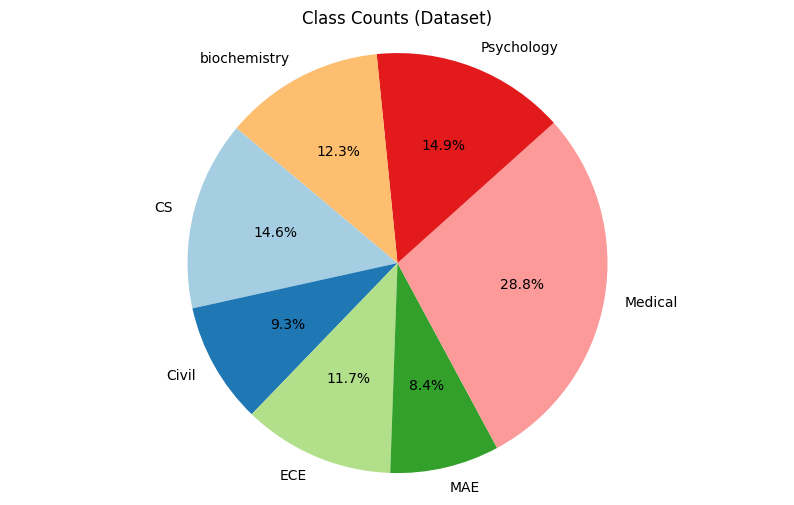

The label CS has 6290 records in the dataset.
The label Civil has 4025 records in the dataset.
The label ECE has 5032 records in the dataset.
The label MAE has 3633 records in the dataset.
The label Medical has 12418 records in the dataset.
The label Psychology has 6450 records in the dataset.
The label biochemistry has 5311 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
abstractslbltest = test_data['Abstract']
keywordsslbltest = test_data['Keywords']
domainlbltest = test_data['Domain']
lblstest = test_data['Label']

In [ ]:
labels = np.unique(domainlbltest, return_counts=True)[0]
labelCounts=  np.unique(domainlbltest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [1483  975 1271  839 3223 1639 1360]


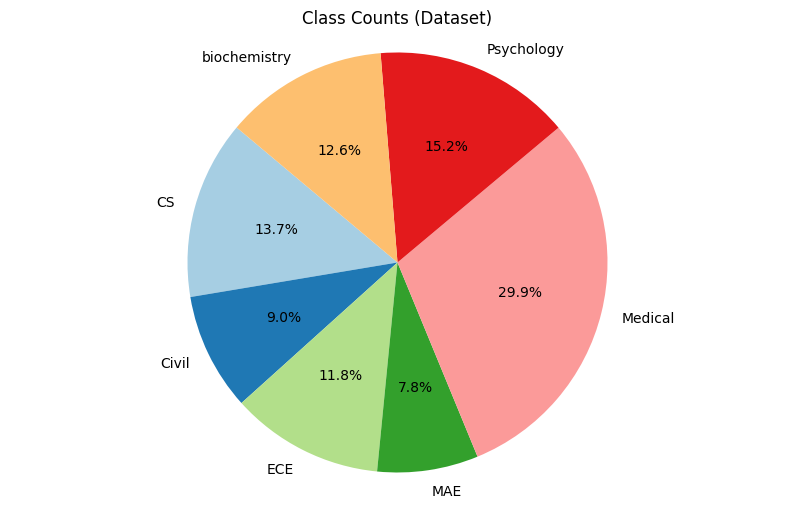

The label CS has 1483 records in the dataset.
The label Civil has 975 records in the dataset.
The label ECE has 1271 records in the dataset.
The label MAE has 839 records in the dataset.
The label Medical has 3223 records in the dataset.
The label Psychology has 1639 records in the dataset.
The label biochemistry has 1360 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
abstractslblval = val_data['Abstract']
keywordsslblval = val_data['Keywords']
domainlblval = val_data['Domain']
lblsval = val_data['Label']

In [ ]:
labels = np.unique(domainlblval, return_counts=True)[0]
labelCounts=  np.unique(domainlblval, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [ 754  464  609  422 1663  823  660]


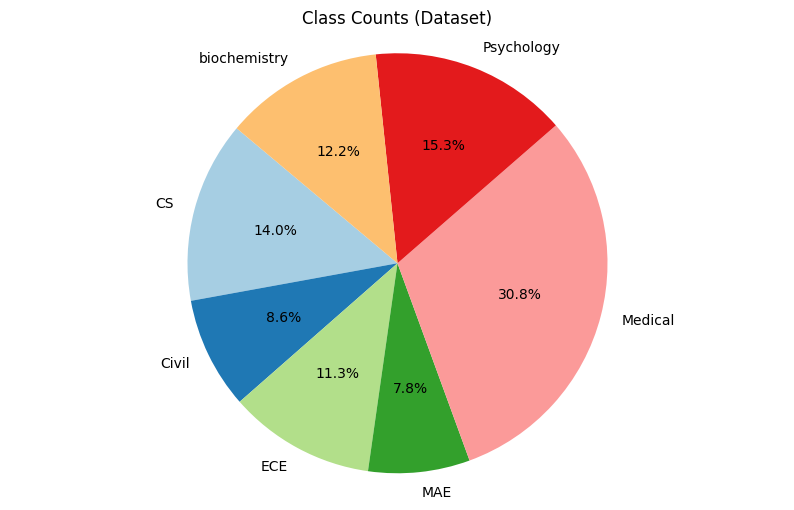

The label CS has 754 records in the dataset.
The label Civil has 464 records in the dataset.
The label ECE has 609 records in the dataset.
The label MAE has 422 records in the dataset.
The label Medical has 1663 records in the dataset.
The label Psychology has 823 records in the dataset.
The label biochemistry has 660 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
def encode_data(data, tokenizer, max_length=128, labeled=True):
    inputs = tokenizer(
        data['combined_text'].tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    if labeled and 'Label' in data.columns:
        labels = torch.tensor(data['Label'].values.astype(int))
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    else:
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'])


In [ ]:
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)

In [ ]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

In [ ]:
print(len(np.unique(train_data['Label'])))
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=len(np.unique(train_data['Label'])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def calculate_metrics_f(valType, predictions, true_labels):
    if valType == 'test':
        cm = confusion_matrix(true_labels, predictions)
        report = classification_report(true_labels, predictions)
        f1_micro = f1_score(true_labels, predictions, average='micro')
        print("\nClassification Report:\n", report)
        return f1_micro
    elif valType == 'val':
        f1_micro = f1_score(true_labels, predictions, average='micro')
        return f1_micro

In [ ]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

       
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [ ]:

epochs = 20
learning_rates = [2e-5, 5e-6, 1e-6, 2e-6]
early_stopping_patience = 5
best_val_f1 = 0
early_stopping_counter = 0

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            model.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

        # Validation
        model.eval()
        predictions, true_labels = [], []
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            batch_predictions = np.argmax(logits, axis=1)
            predictions.extend(batch_predictions)
            true_labels.extend(labels.to('cpu').numpy())
        val_f1 = f1_score(true_labels, predictions, average='micro')
        print(f"Validation Micro F1: {val_f1}")
        val_micro_f1 = calculate_metrics_f('val', predictions, true_labels)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Val Micro F1: {val_micro_f1}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved.")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping applied.")
                break

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded.")


Training with learning rate: 2e-05


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/20: 100%|██████████| 1349/1349 [14:22<00:00,  1.56batch/s]


Train Loss: 0.9493373160211134
Validation Micro F1: 0.8515291936978684
Epoch 1/20, Train Loss: 0.9493373160211134, Val Micro F1: 0.8515291936978684
Best model saved.


Epoch 2/20: 100%|██████████| 1349/1349 [14:24<00:00,  1.56batch/s]


Train Loss: 0.40342515607048973
Validation Micro F1: 0.8635773864689528
Epoch 2/20, Train Loss: 0.40342515607048973, Val Micro F1: 0.8635773864689528
Best model saved.


Epoch 3/20: 100%|██████████| 1349/1349 [14:23<00:00,  1.56batch/s]


Train Loss: 0.3068817570706135
Validation Micro F1: 0.878035217794254
Epoch 3/20, Train Loss: 0.3068817570706135, Val Micro F1: 0.878035217794254
Best model saved.


Epoch 4/20: 100%|██████████| 1349/1349 [14:24<00:00,  1.56batch/s]


Train Loss: 0.225170907654901
Validation Micro F1: 0.8819277108433735
Epoch 4/20, Train Loss: 0.225170907654901, Val Micro F1: 0.8819277108433735
Best model saved.


Epoch 5/20: 100%|██████████| 1349/1349 [14:24<00:00,  1.56batch/s]


Train Loss: 0.1508667860891231
Validation Micro F1: 0.8696941612604263
Epoch 5/20, Train Loss: 0.1508667860891231, Val Micro F1: 0.8696941612604263


Epoch 6/20: 100%|██████████| 1349/1349 [14:25<00:00,  1.56batch/s]


Train Loss: 0.09881791113679048
Validation Micro F1: 0.8759962928637628
Epoch 6/20, Train Loss: 0.09881791113679048, Val Micro F1: 0.8759962928637628


Epoch 7/20: 100%|██████████| 1349/1349 [14:25<00:00,  1.56batch/s]


Train Loss: 0.0641054613812598
Validation Micro F1: 0.8713623725671918
Epoch 7/20, Train Loss: 0.0641054613812598, Val Micro F1: 0.8713623725671918


Epoch 8/20: 100%|██████████| 1349/1349 [14:25<00:00,  1.56batch/s]


Train Loss: 0.04375756373390793
Validation Micro F1: 0.875625579240037
Epoch 8/20, Train Loss: 0.04375756373390793, Val Micro F1: 0.875625579240037


Epoch 9/20: 100%|██████████| 1349/1349 [14:24<00:00,  1.56batch/s]


Train Loss: 0.03098986338315051


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8748841519925857
Epoch 9/20, Train Loss: 0.03098986338315051, Val Micro F1: 0.8748841519925857
Early stopping applied.

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 1349/1349 [14:24<00:00,  1.56batch/s]


Train Loss: 0.014828761551767178


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8765523632993513
Epoch 1/20, Train Loss: 0.014828761551767178, Val Micro F1: 0.8765523632993513
Early stopping applied.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 1349/1349 [14:24<00:00,  1.56batch/s]


Train Loss: 0.008916458987168866


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8782205746061168
Epoch 1/20, Train Loss: 0.008916458987168866, Val Micro F1: 0.8782205746061168
Early stopping applied.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 1349/1349 [14:25<00:00,  1.56batch/s]


Train Loss: 0.007744165019182595
Validation Micro F1: 0.8782205746061168
Epoch 1/20, Train Loss: 0.007744165019182595, Val Micro F1: 0.8782205746061168
Early stopping applied.


<ipython-input-31-99034260d263>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Best model loaded.


In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[1339   41   16   20   18   11   38]
 [  41 1182    5   19   16    3    5]
 [  16   12 1355    8   15  190   43]
 [  19   55   10  710   25   11    9]
 [  23   15    7   25  887    9    9]
 [  17    7  189    8   10 2788  204]
 [   8    1    4    6    5  110 1226]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1483
           1       0.90      0.93      0.91      1271
           2       0.85      0.83      0.84      1639
           3       0.89      0.85      0.87       839
           4       0.91      0.91      0.91       975
           5       0.89      0.87      0.88      3223
           6       0.80      0.90      0.85      1360

    accuracy                           0.88     10790
   macro avg       0.88      0.88      0.88     10790
weighted avg       0.88      0.88      0.88     10790

Macro F1 Score: 0.8811501706006439
Micro F1 Score: 0.8792400370713623
Weighted F1 Score: 0.8

In [ ]:
# Calculate and display test metrics
print("\nTest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))
print("Macro F1:", f1_score(true_labels, predictions, average='macro'))
print("Micro F1:", f1_score(true_labels, predictions, average='micro'))
print("Weighted F1:", f1_score(true_labels, predictions, average='weighted'))


Test Metrics:
Confusion Matrix:
 [[1339   41   16   20   18   11   38]
 [  41 1182    5   19   16    3    5]
 [  16   12 1355    8   15  190   43]
 [  19   55   10  710   25   11    9]
 [  23   15    7   25  887    9    9]
 [  17    7  189    8   10 2788  204]
 [   8    1    4    6    5  110 1226]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1483
           1       0.90      0.93      0.91      1271
           2       0.85      0.83      0.84      1639
           3       0.89      0.85      0.87       839
           4       0.91      0.91      0.91       975
           5       0.89      0.87      0.88      3223
           6       0.80      0.90      0.85      1360

    accuracy                           0.88     10790
   macro avg       0.88      0.88      0.88     10790
weighted avg       0.88      0.88      0.88     10790

Macro F1: 0.8811501706006439
Micro F1: 0.8792400370713623
Weighted F1: 0.87933

In [ ]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
model.save_pretrained('/content/drive/MyDrive/WoS/BioBERT_WoS_53949_records')

In [ ]:
from google.colab import runtime
print('End of the runtime!')
runtime.unassign()